# Pulling COVID-19 Data from the CDC

This tutorial shows how to pull data directly from [data.cdc.gov](data.cdc.gov) via python's Socrata package. Socrata is quite a popular tool in the data field. The City of Chicago also uses Socrata to publish data at [data.cityofchicago.org](data.cityofchicago.org).

The first thing you'll need is an account. Though you can use the following scripts without a Socrata account, doing so means your data pulls will be throttled. 

Go to [data.cdc.gov](dta.cdc.gov) and make an account. You can use either a Socrata account or make an account directly with the CDC. After you have an account, you'll want to go into the account settings area and try to create an account token.

It is best practice to keep passwords and such outside of your script, and there are ways of doing this (environmental variables, etc), but for our purpose, we will just list them below.

In [11]:
socrata_email = "example@email.com"
socrata_password = "examplePassword"
socrata_token = "exampleToken"

Next, we load up the Socrata package. It is part of the `sodapy` package. It must be installed on your system before loading it up. If it isn't installed, you can install it with `pip install sodapy`.

In [2]:
from sodapy import Socrata

Finally, we download the data.

In [3]:
# Open Socrata client
client = Socrata("data.cdc.gov",
                 socrata_token,
                 username=socrata_email,
                 password=socrata_password)
# Download the dataset
data_raw = client.get("9mfq-cb36",limit = 10000000)

As you can see, the data has been downloaded. It is downloaded into a list. Here is the first element of that list.

In [4]:
data_raw[0]

{'submission_date': '2020-10-15T00:00:00.000',
 'state': 'DC',
 'tot_cases': '16166',
 'new_case': '34.0',
 'pnew_case': '0',
 'tot_death': '638',
 'new_death': '0.0',
 'pnew_death': '0',
 'created_at': '2020-10-16T13:33:55.808'}

Personally, I like working with Pandas DataFrame objects. You can convert it quickly as follows:

In [5]:
import pandas as pd
import numpy as np

data_df = pd.DataFrame.from_records(data_raw)
data_df.head()

,submission_date,state,tot_cases,new_case,pnew_case,tot_death,new_death,pnew_death,created_at,consent_cases,consent_deaths,conf_death,prob_death,conf_cases,prob_cases
0,2020-10-15T00:00:00.000,DC,16166,34.0,0,638,0.0,0,2020-10-16T13:33:55.808,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-08T00:00:00.000,NM,109947,0.0,0,1756,0.0,0,2020-12-09T14:45:40.234,N/A,Not agree,NaN,NaN,NaN,NaN
2,2021-01-01T00:00:00.000,FL,1300528,0.0,6063,21673,0.0,7,2021-01-02T14:50:51.219,Not agree,Not agree,NaN,NaN,NaN,NaN
3,2020-08-29T00:00:00.000,SD,12942,425.0,0,167,2.0,0,2020-08-30T14:49:52.418,N/A,Agree,165.0,2,NaN,NaN
4,2020-04-30T00:00:00.000,IA,7145,302.0,0,162,14.0,0,2020-05-01T21:00:19.025,Not agree,Not agree,NaN,NaN,NaN,NaN


Here are the `dtypes` for the columns.

In [6]:
data_df.dtypes

submission_date    object
state              object
tot_cases          object
new_case           object
pnew_case          object
tot_death          object
new_death          object
pnew_death         object
created_at         object
consent_cases      object
consent_deaths     object
conf_death         object
prob_death         object
conf_cases         object
prob_cases         object
dtype: object

As you can see, the columns are all *objects*. If you want `submission_date` to be a date, it can easily be converted. We can also convert `new_death` and `new_case` to numeric.

In [7]:
# This is to handle dates

data_df['submission_date'] = pd.to_datetime(data_df['submission_date'])
data_df['new_death'] = pd.to_numeric(data_df['new_death'])
data_df['new_case'] = pd.to_numeric(data_df['new_case'])

# Visualizing the data

Once you have downloaded the data, you can begin creating visualizations. There are lots of visualization packages out there for Python. Because I came from R, I really like the `plotnine` package.

In [8]:
import plotnine
from plotnine import *

Here's a simple ggplot of reported deaths in Texas.

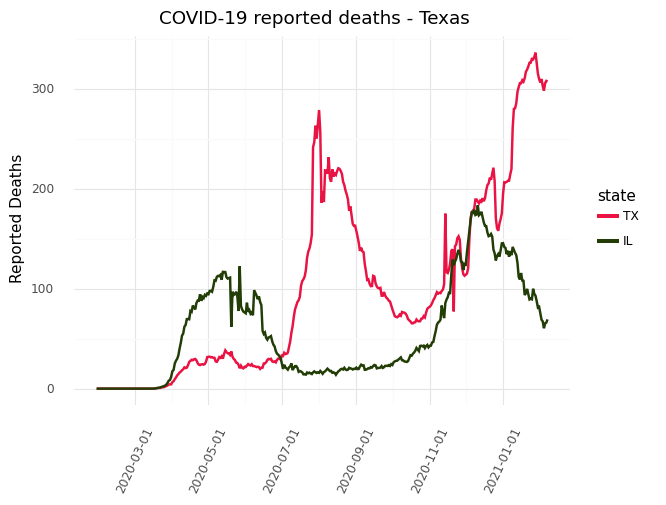

<ggplot: (139084485684)>

In [26]:
p = (ggplot(aes(x = 'submission_date',y = 'new_death',color='state')) +
     # Seven-day moving average for Texas
     geom_smooth(data_df[data_df['state']=='TX'],method='mavg',method_args={'window':7},se = False) +
     # Seven-day moving average for Illinois
     geom_smooth(data_df[data_df['state']=='IL'],method='mavg',method_args={'window':7},se=False) +
     # Theme stuff
     labs(title = 'COVID-19 reported deaths - Texas', x = '', y = 'Reported Deaths') +
     theme_minimal() +
     theme(axis_text_x = element_text(rotation=65, hjust=.5)) +
     # manually set colors of graphs
     scale_color_manual(values=("#E91344","#233D06"))
    )
p